### Sttarter

In [42]:
## loading dataset

## display cluster variation


## unpooled modeling (on entire dataset.)

## pooled modeling (linear regression - cluster based) ~ kinda like parameter estimation


## hierarchical modeling

# definition of fixed effect(individual level) and random effects parameters(cluster-level)
# MCMC sampling (nuts, draws, tunes and stuff)
# posterior distributions
# regression lines


In [43]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

The dataset has 16598 rows and 11 columns.


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


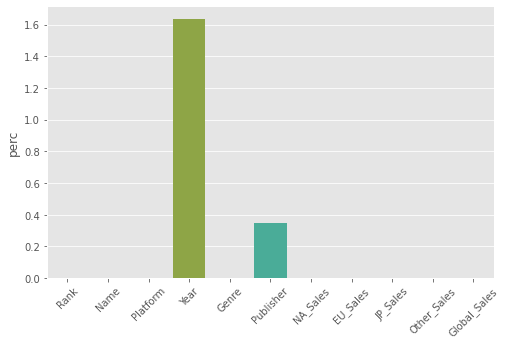

In [44]:
# dataset + abit of preprocessing
def get_data(path):
    # reading dataset
    data = pd.read_csv(path)
    print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

    # preprocessing bits
    null_df = pd.DataFrame((data.isna().sum()/data.shape[0])*100, columns = ['perc'])
    plt.figure(figsize=(8,5))
    sns.barplot(x = null_df.index, y = null_df.perc)
    plt.xticks(rotation = 45)

    # unique values for all categorical columns
    col_unique = {}
    for col in data.columns:
        if data[col].dtype == object:
            col_unique[col] = data[col].unique()


    return data, col_unique

data, unique = get_data('/content/vgsales.csv')
data.head()

In [45]:
# unique

In [46]:
# # a = data.Platform.unique().tolist()
# # a[:15]

# df = ['_' +str(i) for i in range(15)]
# platforms = data.Platform.unique().tolist()
# dfs = []
# for i, j in zip(df, platforms[:15]):
#     i = data.loc[data.Platform == j]
#     dfs.append(i)

# df = dfs[0]
# sns.relplot(df['Other_Sales'], df['Global_Sales'])

In [47]:
""" Exploring the relationship between sales in Europe and sales in NA in the platform clusters.
 Then later we can try double clusters: platform and genre."""

# lets see the cluster variation

# helper functions
def scatter_plot(x, y, h, data):
    plt.figure(figsize = (8,6))
    sns.relplot(data[x], data[y], hue = data[h])
    plt.show()

# pooled scatter plots
def pooled_scatters(data, h):
    df = data[['Platform', 'Genre', 'Other_Sales', 'Global_Sales']]
    # working with 15 random samples
    df = ['_' +str(i) for i in range(15)]
    platforms = data.Platform.unique().tolist()
    dfs = []
    for i, j in zip(df, platforms[:15]):
        i = data.loc[data.Platform == j]
        dfs.append(i)

    for df in dfs:
        plt.figure(figsize = (8,6))
        sns.relplot(df['Other_Sales'], df['Global_Sales'], color = 'gray')
        plt.title(f'{df.Platform.head(1)}')
        plt.show()


# fig, axs = plt.subplots(4, 4)
# axs[0, 0].plot(x, y)
# axs[0, 0].set_title('Axis [0, 0]')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')

<Figure size 576x432 with 0 Axes>

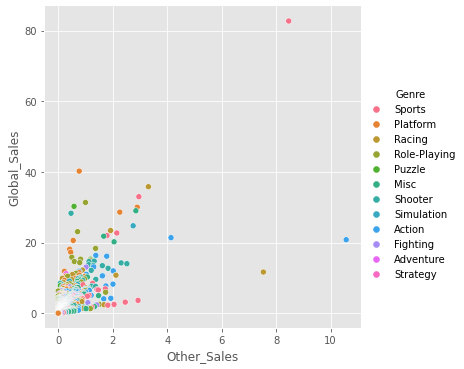

In [48]:
scatter_plot('Other_Sales', 'Global_Sales', 'Genre', data)

In [49]:
# pooled_scatters(data, data['Genre'])

Text(0, 0.5, 'Other Sales')

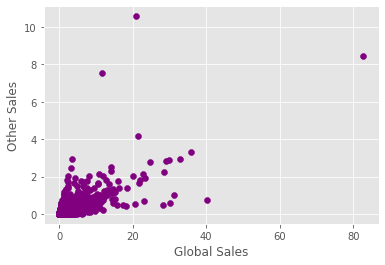

In [50]:
def plot_data(df, ax=None, grp_id=None, **kwargs):
    if not ax:
        fig, ax = plt.subplots()
    ax.scatter(df['Global_Sales'], df['Other_Sales'], color = "purple", **kwargs)
    return ax
    
ax = plot_data(data)
ax.set_xlabel('Global Sales')
ax.set_ylabel('Other Sales')

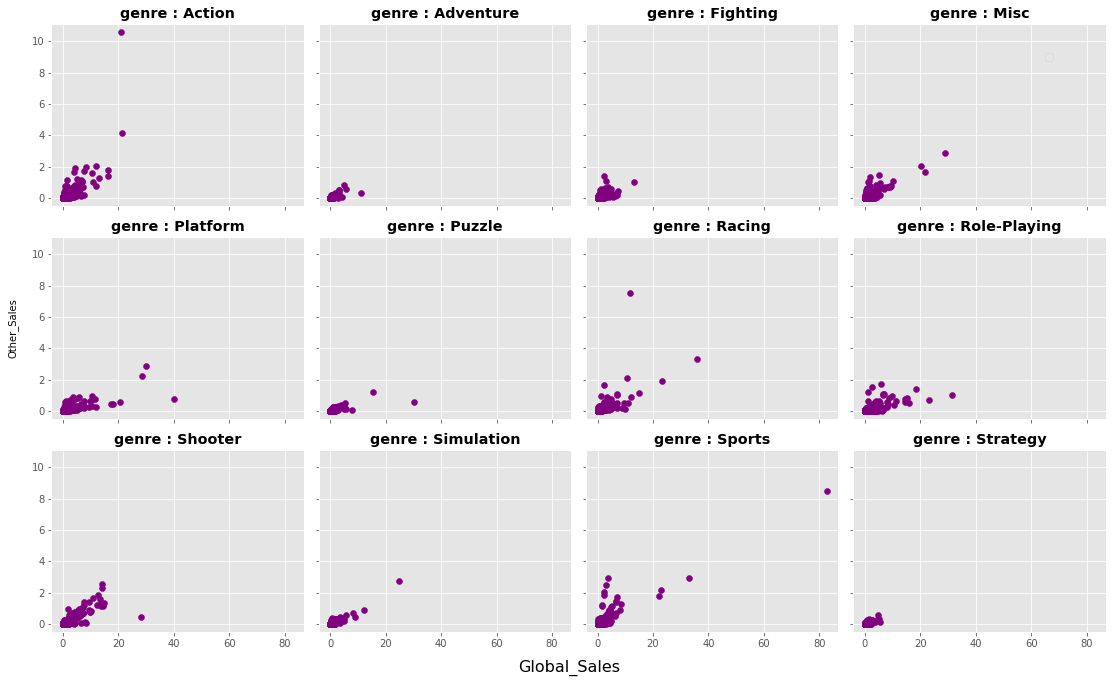

In [51]:
def facetgrid(func):
    """ func is a function that takes the group df, matplotlib axes, group ID
        func must plot using the axes
    """
    fig, ax = plt.subplots(3, 4, figsize=(15,9), 
                           sharex=True, sharey=True,
                            constrained_layout=True)
    
    groups = data.groupby('Genre')  # diff genres
    grp_ids = list(groups.groups)
    
    for i, j in itertools.product(range(3), range(4)):
        grp_id = grp_ids[i * 4 + j]
        func(groups.get_group(grp_id), ax[i,j], grp_id)
        ax[i,j].set_title('genre : ' + str(grp_id), fontweight='bold')
        
    fig.text(0.5, -0.03, 'Global_Sales', ha='center', fontsize=16)
    fig.text(-0.02, 0.5, 'Other_Sales', va='center', rotation='vertical', fontsize=10)
    handles, labels = ax[-1,-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))

facetgrid(plot_data)

There is variation in the different genres, clearly, a single model won't be able to capture this.

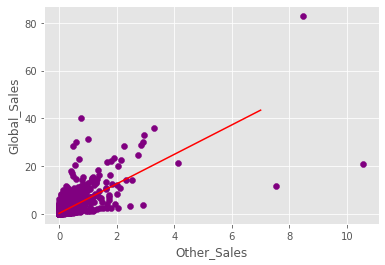

In [52]:
# unpooled modeling

# fitting an ols model on entire dataset to explore relationship between other sales and global sales

from statsmodels.formula.api import ols

unpooled_model = ols('Global_Sales ~ Other_Sales', data).fit()
unpooled_est = unpooled_model.params

o = unpooled_est['Other_Sales']
i = unpooled_est['Intercept']

plt.scatter(data['Other_Sales'], data['Global_Sales'], color = 'purple')
plt.xlabel('Other_Sales')
plt.ylabel('Global_Sales')

# plot line with slope and intercept
def abline(slope, intercept, ax=None, **kwargs):
    """Plot a line from slope and intercept"""
    axes = ax if ax else plt.gca()
    x_vals = np.array([0,7])
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals,  **kwargs)

abline(o, i, linestyle='-', color='red')

Just as stated in the previous markdown cell.
alternative: `sns.regplot(data['Other_Sales'], data['Global_Sales'], ci=None)`

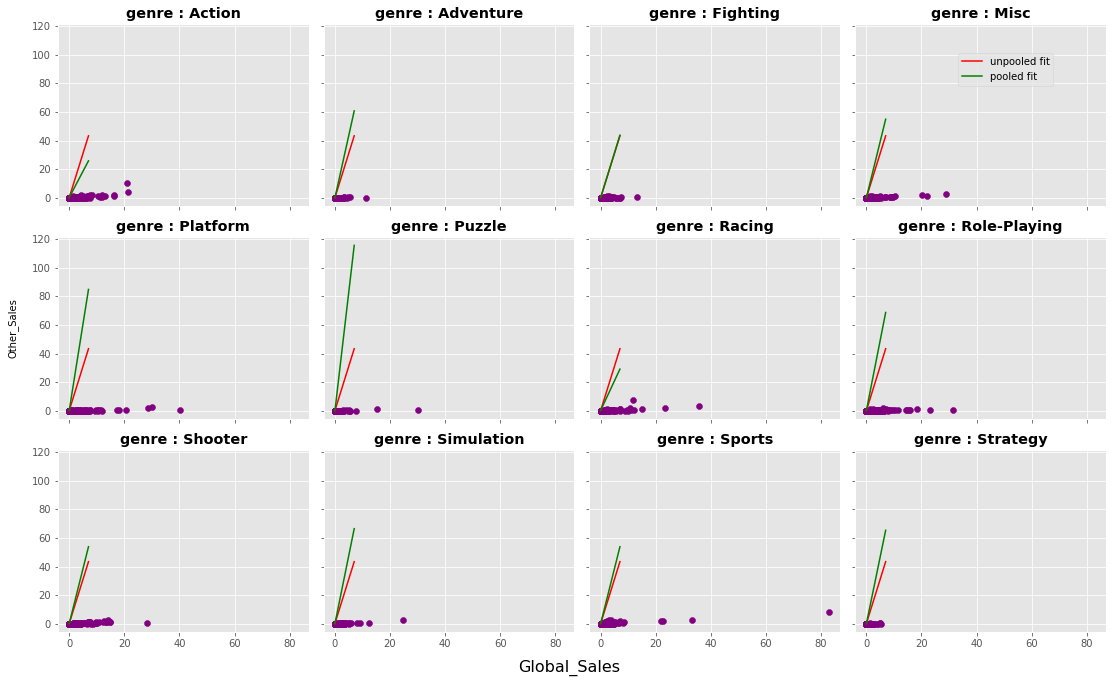

In [53]:
# pooled modeling

pooled_est = {}

def pooled_model(df, ax, grp_id):
    pooled_model = ols('Global_Sales ~ Other_Sales', df).fit()
    pooled_params = pooled_model.params
    
    gp = pooled_params['Other_Sales']
    ip = pooled_params['Intercept']
    
    # save estimates of the group
    pooled_est[grp_id] = (gp, ip)
    
    # plot along with unpooled regression line
    plot_data(df, ax, grp_id)
    abline(o, i, ax, linestyle='-', color='red', label='unpooled fit')
    abline(gp, ip, ax, linestyle='-', color='green', label='pooled fit')
    
facetgrid(pooled_model)

Not much/any better. Pooling is not reliable especially in cases where we have few data points, thus we end up with misleading models.

### HM with pymc3 (PArtial Pooling)

* fixed effects: **genre**
* random effects: 

We will construct hyper priors on our genre/group level parameters to allow the model to share 'sales' level coefficients among the groups withing the data. 

Assuming randomness both in the slope and intercept (hyper prior on both of them):

Model equation:   ​**f(x)=β​0j[i]​​+β​1j[i]**​​

In [54]:
# encoding the genre column

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

genre = encoder.fit_transform(data['Genre'])
n_genres = len(encoder.classes_)
other_sales = data.Other_Sales
global_sales = data.Global_Sales

In [55]:
# my model
with pm.Model() as my_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0, sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5)

    # Intercept for each genre, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_genres).
    # Intercept for each genre, distributed around group mean mu_a
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_genres)
    # slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_genres)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[genre] + b[genre] * other_sales
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=global_sales)

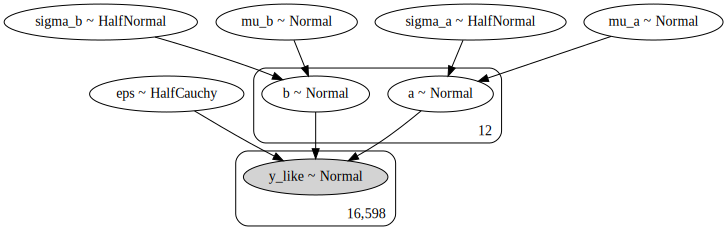

In [56]:
pm.model_to_graphviz(my_model)

In [57]:
with my_model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:27<00:00, 109.66it/s]


In [58]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bebb3b668>,
      dtype=object)

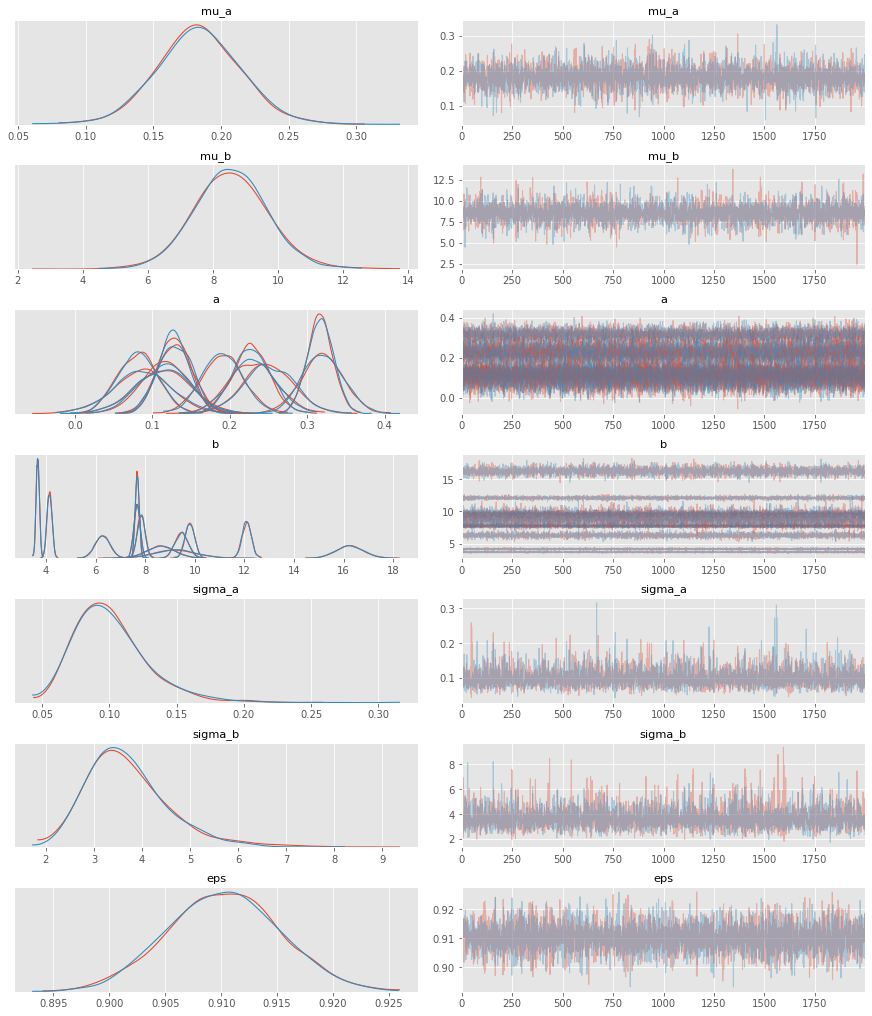

In [59]:
pm.traceplot(trace)

In [60]:
data.shape

(16598, 11)

Text(-0.02, 0.5, 'Genre')

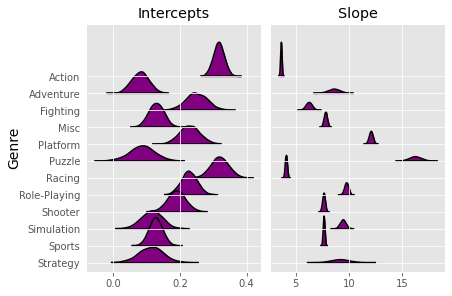

In [61]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

genre_ids  = encoder.classes_[::-1]

pm.forestplot(trace, 'ridgeplot', var_names=['a'], 
              combined=True,
              ridgeplot_overlap=5,
              colors='purple',
              figsize=(5, 10), ax=ax[0])
ax[0].set_title('Intercepts')
ax[0].set_yticklabels(genre_ids)
ax[0].grid()
pm.forestplot(trace, 'ridgeplot', var_names=['b'], 
              combined=True,
              ridgeplot_overlap=5,
              colors='purple',
              figsize=(5, 10), ax=ax[1])
ax[1].set_title('Slope')
ax[1].set_yticklabels(genre_ids)
ax[1].grid()
fig.text(-0.02, 0.5, 'Genre', va='center', rotation='vertical', fontsize=14)

## Regression lines

In [62]:
def plot_posterior_regression_lines(m_p, c_p, ax=None, **kwargs):
    """
    m_p, c_p : posterior samples of slope and intercept respectively
    """
    if not ax:
        fig, ax = plt.subplots()
    
    for (m, c) in zip(m_p, c_p):
        abline(m, c, ax, **kwargs)

Text(0, 0.5, 'Global Sales')

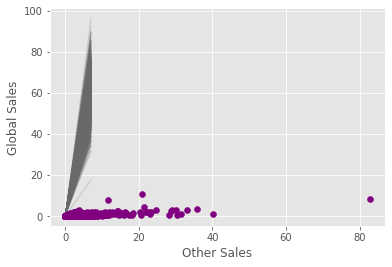

In [63]:
fig, ax = plt.subplots()
plot_posterior_regression_lines(trace['mu_b'], trace['mu_a'], ax, color='dimgray', alpha=0.3, lw=0.8)
# abline(trace['mu_b'].mean(), trace['mu_a'].mean(), ax, color=red, linestyle='-.')
plot_data(data, ax, zorder=3)
ax.set_xlabel('Other Sales')
ax.set_ylabel('Global Sales')

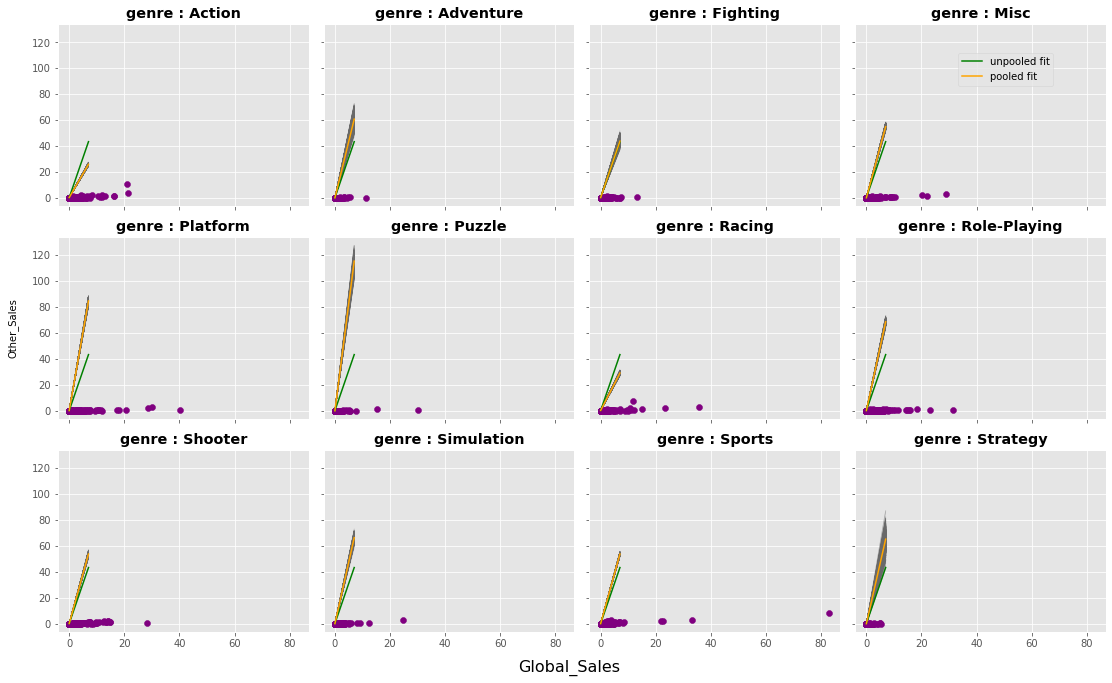

In [64]:
def posterior_plot(df, ax, grp_id):
    grp_label = encoder.transform([grp_id])[0]
    m_p = trace['b'][:,grp_label]
    c_p = trace['a'][:,grp_label]
    
    plot_posterior_regression_lines(m_p, c_p, ax, color='dimgray', alpha=0.3, lw=0.8)
    
    (mp, cp) = pooled_est[grp_id]
    
    plot_data(df, ax, grp_id, zorder=3)
    abline(o, i, ax, linestyle='-', color='green', label='unpooled fit', zorder=4)
    abline(mp, cp, ax, linestyle='-', color='orange', label='pooled fit', zorder=4)
    
facetgrid(posterior_plot)